In [69]:
#!pip install -U pycoingecko
#!pip install pymongo
#!pip install matplotlib

In [77]:
from pycoingecko import CoinGeckoAPI
from pymongo import MongoClient
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

import time
import datetime

cg = CoinGeckoAPI()

### Get a list of all coins with id, name and symbol (using Crypto API)

In [2]:
ids = pd.DataFrame(cg.get_coins_list())

In [3]:
ids.head(10)

,id,symbol,name
0,01coin,zoc,01coin
1,0chain,zcn,Zus
2,0vix-protocol,vix,0VIX Protocol
3,0x,zrx,0x Protocol
4,0x0-ai-ai-smart-contract,0x0,0x0.ai: AI Smart Contract
5,0x1-tools-ai-multi-tool,0x1,0x1.tools: AI Multi-tool
6,0xauto-io-contract-auto-deployer,0xa,0xAuto.io : Contract Auto Deployer
7,0xdao,oxd,0xDAO
8,0xdao-v2,oxd v2,0xDAO V2
9,0xmonero,0xmr,0xMonero


#### Get bitcoin coin id

In [4]:
bitcoin_id = ids.loc[ids['name'].eq('Bitcoin')]
bitcoin_id

,id,symbol,name
1132,bitcoin,btc,Bitcoin


In [5]:
bitcoin_id = bitcoin_id['id'].values[0]
bitcoin_id

'bitcoin'

### Get the price of bitcoin in usd and by date of the first quarter of 2022 (using Crypto API)

In [6]:
from_day = "01-01-2022"
from_day = time.mktime(datetime.datetime.strptime(from_day, "%d-%m-%Y").timetuple())
to_day = "31-03-2022"
to_day = time.mktime(datetime.datetime.strptime(to_day, "%d-%m-%Y").timetuple())
print(from_day,'------>',to_day)

1641016800.0 ------> 1648706400.0


In [7]:
prices = cg.get_coin_market_chart_range_by_id(id=bitcoin_id, from_timestamp=from_day, to_timestamp=to_day, vs_currency='usd')['prices']

In [8]:
prices = pd.DataFrame(prices, columns=['timestamp', 'price'])

In [9]:
prices.timestamp = prices.timestamp.astype(dtype='datetime64[ms]') 

In [10]:
prices = prices.sort_values(by='timestamp').reset_index(drop=True)

In [11]:
prices['date'] = prices['timestamp'].dt.strftime('%Y-%m-%d')

In [12]:
prices = prices.drop_duplicates(subset='date', keep='last')[['date','price']]

In [13]:
prices.head()

,date,price
17,2022-01-01,47506.772711
41,2022-01-02,47406.938417
65,2022-01-03,46280.983265
89,2022-01-04,46164.781388
113,2022-01-05,43265.684197


In [14]:
json_prices = prices.set_index('date')['price'].to_dict()

 #### Save the information in the database of your choice

In [103]:
MONGO_URI = 'mongodb://localhost'
cl = MongoClient(MONGO_URI)
db = cl['Ktest']
coll = db['bitcoin']
_id = '1_4-2022'

In [104]:
json_prices['_id']=_id

In [105]:
coll.insert_one(json_prices)

In [106]:
result = coll.find_one(_id)


In [107]:
result

{'_id': '1_4-2021',
 '2021-01-01': 29304.080786717124,
 '2021-01-02': 31985.94327590237,
 '2021-01-03': 33519.65289891831,
 '2021-01-04': 31362.626599145162,
 '2021-01-05': 34353.95313019863,
 '2021-01-06': 36431.03531171999,
 '2021-01-07': 39541.418127295794,
 '2021-01-08': 40677.303351286086,
 '2021-01-09': 40188.33488211669,
 '2021-01-10': 38478.77380426502,
 '2021-01-11': 35317.07488213626,
 '2021-01-12': 33832.38759099165,
 '2021-01-13': 37485.357218425386,
 '2021-01-14': 38924.24637279073,
 '2021-01-15': 36547.34076280214,
 '2021-01-16': 36056.60556729188,
 '2021-01-17': 36259.301075196585,
 '2021-01-18': 36482.80474851915,
 '2021-01-19': 36483.70793833089,
 '2021-01-20': 35059.507745550494,
 '2021-01-21': 31073.476756780314,
 '2021-01-22': 32835.39231503844,
 '2021-01-23': 32073.225469437875,
 '2021-01-24': 32114.070569831772,
 '2021-01-25': 32483.657028657017,
 '2021-01-26': 32639.758582145012,
 '2021-01-27': 30624.65494170474,
 '2021-01-28': 33351.39764011169,
 '2021-01-29': 3

In [108]:
cl.close()

### Consume the data previously persisted in the database to make a window/partition function for every 5 days (spark or pandas)

In [46]:
MONGO_URI = 'mongodb://localhost'
cl = MongoClient(MONGO_URI)
db = cl['Ktest']
coll = db['bitcoin']
_id = '1_4-2022'
result = db.bitcoin.find()

In [47]:
data = result[0]
cl.close()

In [48]:
del data["_id"]

In [49]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['price'])

In [50]:
df = df.reset_index().rename(columns={'index': 'date'})
df.date = df.date.astype(dtype='datetime64[ms]') 

In [51]:
df = df.set_index('date').resample('5D').mean().reset_index()

In [52]:
df.head()

,date,price
0,2022-01-01,46125.031996
1,2022-01-06,42147.936410
2,2022-01-11,43233.834910
3,2022-01-16,42270.310096
4,2022-01-21,35884.636485


#### Extra point: Save the information in the database of your choice

In [53]:
MONGO_URI = 'mongodb://localhost'
cl = MongoClient(MONGO_URI)
db = cl['Ktest']
coll = db['bitcoin_avg5']
_id = '1_4-2022'

In [54]:
df.date = df.date.dt.strftime('%Y-%m-%d')
json_prices_avg = df.set_index('date')['price'].to_dict()

In [60]:
json_prices_avg['_id']=_id
coll.insert_one(json_prices_avg)

In [62]:
result = db.bitcoin_avg5.find()
for data in result:
    print(data)

{'_id': ObjectId('64bf16ff26b572470e28ac73'), '2022-01-01': 46125.03199565636, '2022-01-06': 42147.936410077586, '2022-01-11': 43233.83490977994, '2022-01-16': 42270.31009590753, '2022-01-21': 35884.63648526014, '2022-01-26': 37512.07346673661, '2022-01-31': 38409.00590624074, '2022-02-05': 43269.85823002855, '2022-02-10': 42688.48028438092, '2022-02-15': 41855.216496255685, '2022-02-20': 38001.123108333915, '2022-02-25': 40838.87898106293, '2022-03-02': 40852.1624476934, '2022-03-07': 39436.85194766453, '2022-03-12': 39413.094945600926, '2022-03-17': 41463.592017440904, '2022-03-22': 43540.582697230355, '2022-03-27': 47089.93300107693}
{'_id': ObjectId('64bf174d26b572470e28ac77'), '2022-01-01': 46125.03199565636, '2022-01-06': 42147.936410077586, '2022-01-11': 43233.83490977994, '2022-01-16': 42270.31009590753, '2022-01-21': 35884.63648526014, '2022-01-26': 37512.07346673661, '2022-01-31': 38409.00590624074, '2022-02-05': 43269.85823002855, '2022-02-10': 42688.48028438092, '2022-02-15

In [63]:
cl.close()

### Using the tool of your choice show the results obtained in a graph

C:\Users\Tomoy\AppData\Local\Temp\ipykernel_20076\3540121578.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


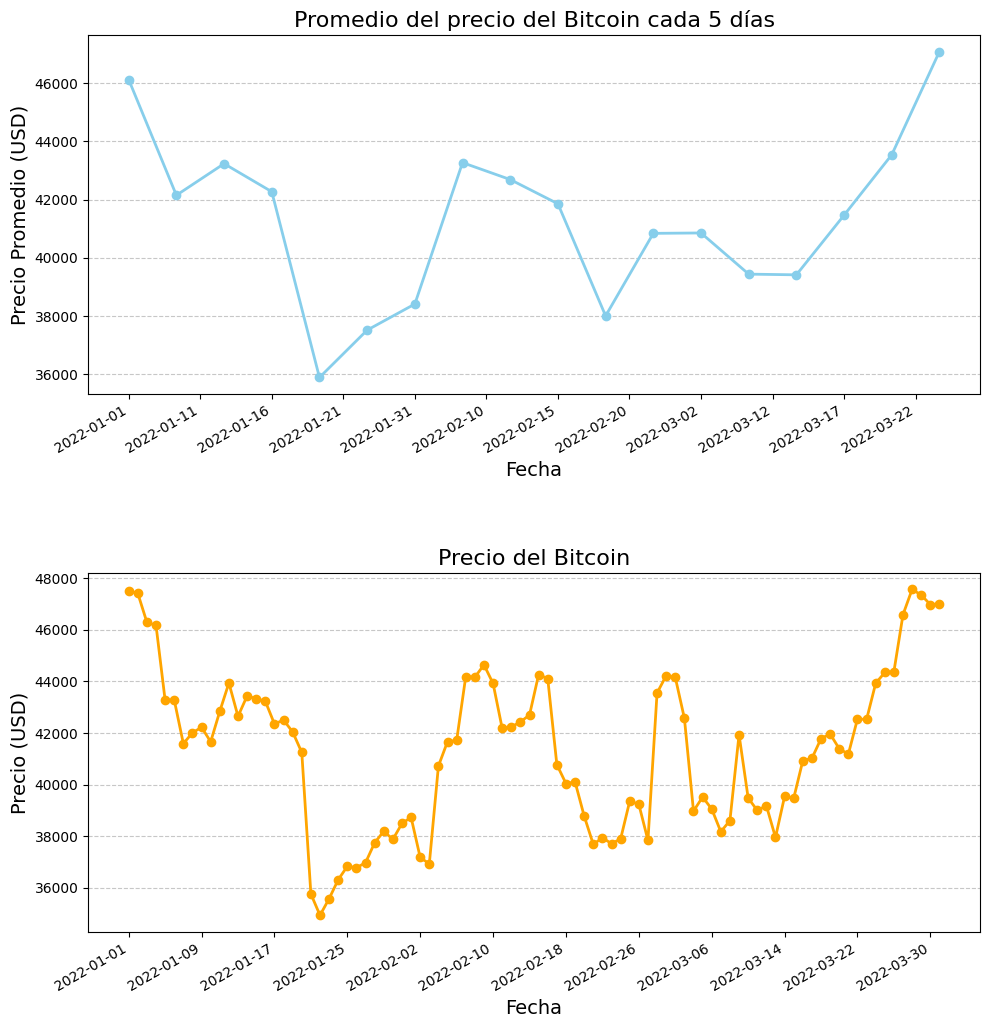

In [90]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(df['date'], df['price'], marker='o', color='skyblue', linestyle='-', linewidth=2)
ax1.set_title('Promedio del precio del Bitcoin cada 5 días', fontsize=16)
ax1.set_xlabel('Fecha', fontsize=14)
ax1.set_ylabel('Precio Promedio (USD)', fontsize=14)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=15))  
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2.plot(prices['date'], prices['price'], marker='o', color='orange', linestyle='-', linewidth=2)
ax2.set_title('Precio del Bitcoin', fontsize=16)
ax2.set_xlabel('Fecha', fontsize=14)
ax2.set_ylabel('Precio (USD)', fontsize=14)
ax2.xaxis.set_major_locator(MaxNLocator(nbins=15)) 
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

for ax in fig.get_axes():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.subplots_adjust(hspace=0.5)

plt.show()